<a href="https://colab.research.google.com/github/Jaime44/WorkSpace/blob/main/models/colaborative%20filter/movie-recommendation-system-collaborative-filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/jaime44/movie-recommendation-system-collaborative-filter/edit

In [1]:
import os
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/Models/colaborative filter'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = os.getcwd().replace("\\", "/")

datasets_path = "/datasets/"
path_absolute = path_absolute+datasets_path

El código se está ejecutando en un entorno local.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Collaborative Filtering**

<small>Collaborative filtering is a technique that can filter out items that a user might like on the basis of reactions by similar users.

It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

There are many ways to decide which users are similar and combine their choices to create a list of recommendations</small>

El filtrado colaborativo es una técnica que puede filtrar elementos que podrían gustar a un usuario basándose en las reacciones de usuarios similares.

Funciona buscando en un grupo grande de personas y encontrando un conjunto más pequeño de usuarios con gustos similares a los de un usuario concreto. Observa los artículos que les gustan y los combina para crear una lista clasificada de sugerencias.

Hay muchas formas de decidir qué usuarios son similares y combinar sus elecciones para crear una lista de recomendaciones

![colaborative filtering.png](attachment:5c14f24e-aec1-4538-9e9e-c3361ecad485.png)

En nuestro proyecto utilizamos el método de correlación

# 1.Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print("libraries imported..")

libraries imported..


# 2. load two datasets

In [4]:
rating = pd.read_csv(path_absolute+"Dataset.csv")

In [5]:
rating.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [6]:
movie = pd.read_csv(path_absolute+"Movie_Id_Titles.csv")

In [7]:
movie.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


# 3. Merge both the datasets based on Itemid

In [8]:
 df = pd.merge(movie,rating, on='item_id')

In [9]:
df.head()

,item_id,title,user_id,rating,timestamp
0,1,Toy Story (1995),308,4,887736532
1,1,Toy Story (1995),287,5,875334088
2,1,Toy Story (1995),148,4,877019411
3,1,Toy Story (1995),280,4,891700426
4,1,Toy Story (1995),66,3,883601324


In [10]:
ratings = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')
print(ratings.shape)
df_ratings_merge = ratings.copy()
df_ratings_merge = df_ratings_merge.sample(n=30000, random_state=42)
# Inserta la columna 'rating' en la última posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-1, 'rating', df_ratings_merge.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-2, 'relevance', df_ratings_merge.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
df_ratings_merge.insert(5, 'tag_etiquetas_genómicas', df_ratings_merge.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
df_ratings_merge.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas:
columnas_a_eliminar = ['imdbId', 'tmdbId']
df_ratings_merge = df_ratings_merge.drop(columnas_a_eliminar, axis=1)
print(df_ratings_merge.shape)
df_ratings_merge.head()

df = df_ratings_merge.copy()

(8949372, 13)
(30000, 11)


# 4.EDA

In [11]:
df.shape

(30000, 11)

In [12]:
df['rating'].value_counts()

4.0    6844
5.0    6312
4.5    5107
3.5    4625
3.0    2997
2.5    1502
2.0    1128
1.5     573
1.0     489
0.5     423
Name: rating, dtype: int64

In [13]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Breakdown (1997)                                  5.0
Human Centipede II (Full Sequence), The (2011)    5.0
Honey, I Shrunk the Kids (1989)                   5.0
Hoop Dreams (1994)                                5.0
Requiem for the American Dream (2015)             5.0
What a Girl Wants (2003)                          5.0
The Distinguished Citizen (2016)                  5.0
Reprise (2006)                                    5.0
Anna and the King (1999)                          5.0
Hostel: Part II (2007)                            5.0
Name: rating, dtype: float64

# 5.Visualisation

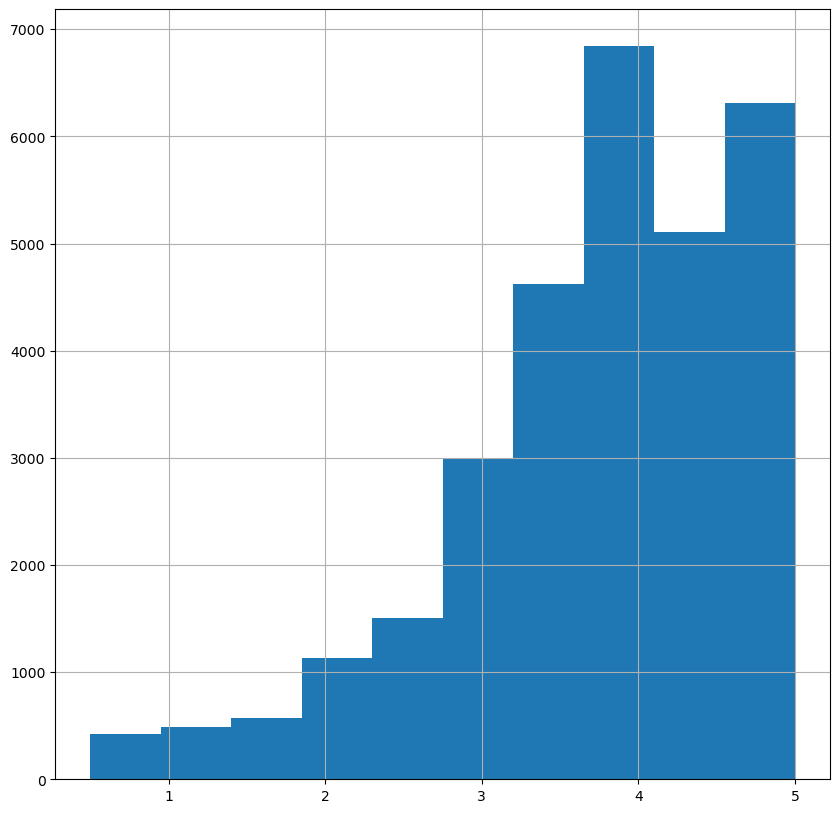

In [14]:
df['rating'].hist(figsize= (10,10))
plt.show()

C:\Users\jaime\AppData\Local\Temp\ipykernel_32108\1971095500.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  tc = df.corr()


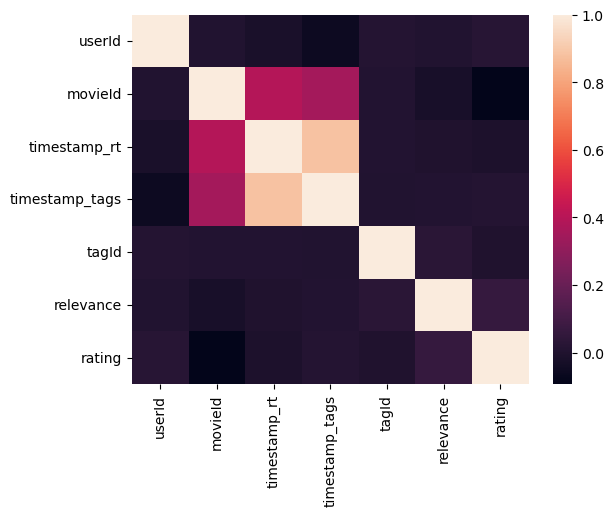

In [15]:
tc = df.corr()
sns.heatmap(tc)
plt.show()


# 6.create a ratings dataframe with average rating and number of ratings

In [16]:
ratings =pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'71 (2014),4.500000
'Salem's Lot (2004),5.000000
"'burbs, The (1989)",3.500000
'night Mother (1986),4.000000
(500) Days of Summer (2009),4.213115


In [17]:
ratings['rating_numbers'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [18]:
ratings.head()

,rating,rating_numbers
title,,
'71 (2014),4.500000,2
'Salem's Lot (2004),5.000000,1
"'burbs, The (1989)",3.500000,4
'night Mother (1986),4.000000,1
(500) Days of Summer (2009),4.213115,61


# 7. Create Pivot table

In [19]:
df.head()

,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
1561133,60101,2571,1053445162,dystopia,1244667471,hitman,"Matrix, The (1999)",Action|Sci-Fi|Thriller,512,0.12625,5.0
1499330,42923,1228,1330057917,classic,1330057913,nocturnal,Raging Bull (1980),Drama,710,0.60700,4.0
1048680,7620,34532,1144937579,Magick,1144937622,true story,"Skeleton Key, The (2005)",Drama|Horror|Mystery|Thriller,1047,0.05750,5.0
1703441,62199,5636,1199318408,Anthony Russo,1328741490,adoption,Welcome to Collinwood (2002),Comedy|Crime,27,0.05325,3.0
5648649,29801,6250,1476349149,Stephen King,1476349186,cult film,Dreamcatcher (2003),Drama|Horror|Sci-Fi|Thriller,276,0.36500,2.0


## Esta matriz (movieRate) es una representación de las calificaciones dadas por los usuarios a las películas. Las filas representan usuarios, las columnas representan títulos de películas y los valores son las calificaciones. Las celdas que no tienen calificación se llenan con ceros.

In [20]:
movieRate = df.pivot_table(index='userId', columns='title', values='rating')
movieRate.fillna(0, inplace=True)

In [21]:
movieRate.head()

title,'71 (2014),'Salem's Lot (2004),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),+1 (2013),...And Justice for All (1979),10 (1979),10 Cloverfield Lane (2016),...,Zombieland (2009),Zoolander (2001),Zoolander 2 (2016),Zootopia (2016),[REC] (2007),[REC]² (2009),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 8.Recommendation system

Calcular la correlación entre la película de entrada (la película para la cual queremos hacer recomendaciones) y todas las demás películas en la matriz movieRate

Calcula la **correlación de Pearson** entre las calificaciones de cada película en movieRate y las calificaciones del usuario especificado por user_rating.
La función **corrwith** compara las calificaciones de la película de entrada con las calificaciones de cada otra película en términos de su similitud. Esto puede ayudar a identificar películas que tienen calificaciones similares por parte de los usuarios.


La variable min_rating_count en el código que proporcionaste es un umbral utilizado para filtrar las películas recomendadas basándose en el número mínimo de calificaciones que deben tener. Veamos cómo se utiliza en la función

In [22]:
def recommendMovies(name , min_rating_count = 50):
    user_rating = movieRate[name]
    similar_movies = movieRate.corrwith(user_rating)
    corr_movies = pd.DataFrame(similar_movies, columns=['Correlation'])
    corr_movies.dropna(inplace=True)
    #corr_movies.sort_values('Correlation', ascending=False).head(10)
    # Joining the rating_number list so that we can filter basis minimum count of ratings to be considered
    # for recommending a movie
    corr_movies = corr_movies.join(ratings['rating_numbers'], how='left', lsuffix='_left', rsuffix='_right')

    final = corr_movies[corr_movies['rating_numbers']>min_rating_count].sort_values('Correlation', ascending=False)
    return final

In [23]:
user_rating = movieRate["Harry Potter and the Goblet of Fire (2005)"]
similar_movies = movieRate.corrwith(user_rating)
corr_movies = pd.DataFrame(similar_movies, columns=['Correlation'])
corr_movies.dropna(inplace=True)

In [24]:
recommendations = recommendMovies('Harry Potter and the Goblet of Fire (2005)')
recommendations.head(n=10)

,Correlation,rating_numbers
title,,
"Wolf of Wall Street, The (2013)",0.169063,89
Mr. Nobody (2009),0.127147,63
Eternal Sunshine of the Spotless Mind (2004),0.104735,58
Shutter Island (2010),0.098319,90
American Beauty (1999),0.096950,78
"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",0.083046,119
"Dark Knight, The (2008)",0.078645,85
Good Will Hunting (1997),0.072983,73
WALL·E (2008),0.069284,51


# Conclusion

1. we build a collaborative recommendation system to recommend movies.
2. memory based approch is used.

**Enfoques colaborativos basados en la memoria**

Las principales características de usuario-usuario e ítem-ítem se aproximan a que utilizan solo información de la matriz de interacción usuario-ítem y no asumen ningún modelo para producir nuevas recomendaciones.


## Similitud con Pearson 
**.corr()**

**df.corr(method='pearson'):**

Esta función calcula la correlación entre las columnas de un DataFrame.
method='pearson' indica que se está utilizando el coeficiente de correlación de Pearson, que mide la correlación lineal entre dos variables continuas. Toma valores entre -1 y 1, donde 1 significa una correlación positiva perfecta, -1 significa una correlación negativa perfecta, y 0 significa ausencia de correlación lineal.
En el contexto del código que proporcionaste, se utiliza para calcular la correlación entre todas las columnas del DataFrame df.

In [25]:
ratings = df.copy()

In [26]:
userRatings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
userRatings.head()
print("Before: ",userRatings.shape)
userRatings = userRatings.dropna(thresh=10, axis=1).fillna(0,axis=1)
#userRatings.fillna(0, inplace=True)
print("After: ",userRatings.shape)

Before:  (4369, 5812)
After:  (4369, 600)


In [27]:
corrMatrix = userRatings.corr(method='pearson')
corrMatrix.head()

title,(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),12 Angry Men (1957),127 Hours (2010),2001: A Space Odyssey (1968),2012 (2009),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",...,X-Men: First Class (2011),X-Men: The Last Stand (2006),X2: X-Men United (2003),Yes Man (2008),Your Name. (2016),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),[REC] (2007)
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),1.000000,0.079470,0.025530,0.044719,0.039695,0.004368,-0.005330,-0.007893,-0.006972,-0.005761,...,-0.005010,-0.004227,-0.005323,0.094485,0.025544,0.032358,0.022235,-0.005407,-0.007161,0.029878
10 Cloverfield Lane (2016),0.079470,1.000000,0.062743,0.016902,-0.003102,0.076167,-0.003249,0.068830,-0.004251,-0.003512,...,0.027423,-0.002577,-0.003245,-0.002832,0.072550,0.118810,0.085849,-0.003297,0.116086,0.064227
10 Things I Hate About You (1999),0.025530,0.062743,1.000000,-0.003874,-0.002588,0.059734,0.015901,-0.004014,-0.003546,0.032663,...,-0.002548,0.109036,0.074037,-0.002363,-0.002456,-0.003664,0.048237,-0.002750,-0.003642,-0.002486
12 Angry Men (1957),0.044719,0.016902,-0.003874,1.000000,0.030576,0.004981,-0.004285,-0.006346,-0.005606,-0.004632,...,0.011112,-0.003399,-0.004280,-0.003735,0.041837,0.061698,-0.006617,-0.004348,0.047975,-0.003930
127 Hours (2010),0.039695,-0.003102,-0.002588,0.030576,1.000000,-0.005617,-0.002863,-0.004240,-0.003745,-0.003094,...,-0.002691,-0.002271,-0.002859,-0.002495,-0.002594,0.031291,0.071004,-0.002905,-0.003847,-0.002625


In [28]:
def get_similar(movie_name,rating):
    similar_ratings = corrMatrix[movie_name]*(rating-2.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    #print(type(similar_ratings))
    return similar_ratings

In [29]:
romantic_lover = [("(500) Days of Summer (2009)",5),("Alice in Wonderland (2010)",3),
                  ("Aliens (1986)",1),("2001: A Space Odyssey (1968)",2)]
similar_movies = pd.DataFrame()
for movie,rating in romantic_lover:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)

similar_movies.head(14)
similar_movies.sum().sort_values(ascending=False).head(14)

C:\Users\jaime\AppData\Local\Temp\ipykernel_32108\2499626287.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
C:\Users\jaime\AppData\Local\Temp\ipykernel_32108\2499626287.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
C:\Users\jaime\AppData\Local\Temp\ipykernel_32108\2499626287.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)
C:\Users\jaime\AppData\Local\Temp\ipykernel_32108\2499626287.py:5: FutureWarning: The frame.append method is deprecated and will be remo

title
(500) Days of Summer (2009)                       2.487918
Big Fish (2003)                                   0.434354
Alice in Wonderland (2010)                        0.406069
Aeon Flux (2005)                                  0.333582
Separation, A (Jodaeiye Nader az Simin) (2011)    0.297235
Virgin Suicides, The (1999)                       0.281546
Yes Man (2008)                                    0.243989
Before Sunset (2004)                              0.242406
Time Traveler's Wife, The (2009)                  0.234057
Adventureland (2009)                              0.217912
Blue Valentine (2010)                             0.211308
Bridesmaids (2011)                                0.210968
Coherence (2013)                                  0.204631
50/50 (2011)                                      0.202725
dtype: float64

In [30]:
action_lover = [("Amazing Spider-Man, The (2012)",5),("Mission: Impossible III (2006)",4),
                ("Toy Story 3 (2010)",2),("2 Fast 2 Furious (Fast and the Furious 2, The) (2003)",4)]
similar_movies = pd.DataFrame()
for movie,rating in action_lover:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)

similar_movies.head(10)
similar_movies.sum().sort_values(ascending=False).head(14)

C:\Users\jaime\AppData\Local\Temp\ipykernel_32108\2666596755.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)


KeyError: 'Mission: Impossible III (2006)'

In [31]:
movies = [("Harry Potter and the Goblet of Fire (2005)",4)]
similar_movies = pd.DataFrame()
for movie,rating in movies:
    similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)

similar_movies.head(10)
similar_movies.sum().sort_values(ascending=False).head(14)

C:\Users\jaime\AppData\Local\Temp\ipykernel_32108\1170701911.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating),ignore_index = True)


title
Harry Potter and the Goblet of Fire (2005)                                                        1.500000
The Intern (2015)                                                                                 0.361768
Armageddon (1998)                                                                                 0.346673
Harry Potter and the Deathly Hallows: Part 1 (2010)                                               0.312192
The Interview (2014)                                                                              0.304631
It (2017)                                                                                         0.271346
Breakfast Club, The (1985)                                                                        0.260525
Wolf of Wall Street, The (2013)                                                                   0.253595
Thor (2011)                                                                                       0.240914
Taken (2008)                   